# Feature-view on Data Cubes

In the Earth observation domain, a coverage should be seen a thematic, spatio-temporal attribute of a feature, as it is also defined in the General Feature Model. A coverage is attached to one (or more?) features as the surface of the Earth is attached to the Earth itself. A field, in most cases represented as coverage, e.g., colour, has no-data values: it either exists or does not exist. In the broadest sense a coverage, covering the whole Earth is attached to the feature Earth, the colour variance within Africa is attached to the feature Africa, the temperature variance of an agricultural field is attached to the agricultural field as a feature.

More explaination about features, coverages, event and processes here.

## Example: Irrigated agriculture in Egypt with Sentinel-2



## 1. Description

Identifying agricultural fields in Egypt with a irrigation system, which is called ["center pivot irrigation"](https://en.m.wikipedia.org/wiki/Center_pivot_irrigation). A rotating sprinkler system generates the typical round areas: ![](https://upload.wikimedia.org/wikipedia/commons/1/17/PivotIrrigationOnCotton.jpg)

Satellite images can be used to document the extent and amount of the fields [as illustrated by this example using images from the Proba-V satellite](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba-v/image-of-the-week/-/article/pivot-irrigation-fields-egypt)

![](https://earth.esa.int/documents/10174/2555664/Proba-V-2014-2016-Pivot-Irrigation-Fields-Egypt-full.jpg)

Images from this area makes it a good testbed for Object-Based Image Analysis (OBIA) in data cubes:
- The resultion of Sentinel-2 is high enough to capture the fields and its details
- Images from this area are not frequently obscurred by clouds
- As shown in the example, the area is quite dynamic and allows to investigate temporal patterns.

This is a simple example, whichs serves as a first test.

## 2. Steps to be completed prior to the analysis
Make sure the file s2-workflow.sh was executed successfully, then import the datacube.

In [1]:
%matplotlib inline
import datacube

## 3. Loading data of the study area

Load the datacube and list the available product. The interesting ones are those having the name "s2a_sen2cor_granule", referring to the indexed Sentinel-2 Level 2 Bottom of Atmosphere (BOA) surface reflectance values, and "s2a_sen2cor_granule_ingested_10", referring to the ingested 10 m bands.

In [2]:
dc = datacube.Datacube()
dc.list_products()

,name,description,product_type,lon,creation_time,format,platform,instrument,time,label,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
1,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,S2MSI1C,None,None,JPEG2000,Sentinel-2A,MSI,None,None,None,NaN,NaN,NaN,NaN
3,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,S2MSI2Ap,None,None,JPEG2000,SENTINEL_2A,MSI,None,None,None,NaN,NaN,NaN,NaN
4,s2a_sen2cor_granule_ingested_10,Sentinel-2A MSI L2A 10 metre,S2MSI2Ap,None,None,NetCDF,SENTINEL_2A,MSI,None,None,None,EPSG:32635,"(-10, 10)","(100000.0, 100000.0)","(y, x)"
2,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,S2MSI1C,None,None,JPEG2000,Sentinel-2B,MSI,None,None,None,NaN,NaN,NaN,NaN


Load subset of the data cube, which will be referred to as "study area" below. The successful loading of the study area will be indicated by a Dataset type of the xarray module with 1 temporal and two spatial dimensions, whose length is larger than 1 (in space) and larger than 0 (in time). The values are of the type int16 and are not "Nan". The spatial reference system is the original UTM zone with EPSG Code 32635.

In [37]:
study_area = dc.load(product='s2a_sen2cor_granule_ingested_10', x=(661741, 693067), y=(2449603,2465032), crs='EPSG:32635')
print(study_area)

<xarray.Dataset>
Dimensions:  (time: 1, x: 3133, y: 1544)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-09T08:50:22.975000
  * y        (y) float64 2.465e+06 2.465e+06 2.465e+06 2.465e+06 2.465e+06 ...
  * x        (x) float64 6.617e+05 6.618e+05 6.618e+05 6.618e+05 6.618e+05 ...
Data variables:
    blue     (time, y, x) int16 1937 1883 1910 1920 1949 1967 1925 1926 1958 ...
    green    (time, y, x) int16 3212 3218 3305 3286 3276 3278 3216 3237 3268 ...
    red      (time, y, x) int16 4844 4790 4914 4904 4973 4930 4806 4800 4830 ...
    nir      (time, y, x) int16 5546 5450 5628 5588 5639 5633 5547 5505 5543 ...
Attributes:
    crs:      EPSG:32635


Calculate the NDVI. The NDVI (Normalized Difference Vegetation Index) can be used to identify the health status of vegetation through the difference of reflection in red and near infrared bands. This is determined by the water content within the cells of the plants, which is a proxy of the health. The NDVI is often used to discriminate between vegetation and non-vegetation by assuming high NDVI values indicate presence of vegetation and low values indicate absence of vegetation. Although, this is not always reliable because other factors can generate high NDVI values as well, it is used in this example:

In [4]:
nir = study_area.nir
red = study_area.red
ndvi = ((nir - red) / (nir + red))

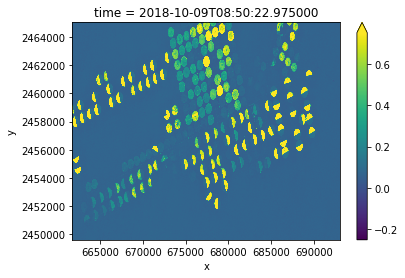

In [5]:
ndvi.plot(vmin=-0.25, vmax=0.75)

## 4. Putting on the glasses with the feature view

### Question 1:
How many irrigated agricultural fields are within this area and how many of them are fully used and how many are only partially used?

In [1]:
from rhino import rhino

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Set the property we want to analyse, in this case the NDVI and get all values greater than 0.2

In [2]:
atom_property = rhino.Property("ndvi")
atom_property.setSimilarityFunction(
    {
        "property":"ndvi",
        "value":0.2,
        "operator": "gt"
    })

Load the data cube, this can take a while

In [3]:
dc = rhino.Datacube(show_progress = False, atom_property=atom_property)

dc.load(
    product = "s2a_sen2cor_granule_ingested_10",
    boundingbox = {"x":(676388, 680313), "y":(2453906,2459794), "crs":'EPSG:32635'}
)

In [4]:
objects, coverage, level = dc.execute("aggregation", parameters = None, level = 0)

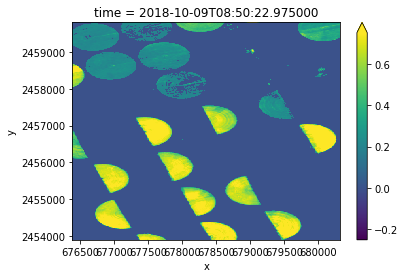

In [13]:
coverage.getStupidArray().plot(vmin=-0.25, vmax=0.75)

In [5]:
print("Number of objects: " + str(len(objects)))

Number of objects: 96


In [9]:
from geojson import Feature, Polygon, FeatureCollection
features = []
for i, obj in enumerate(objects):
    features.append(
        Feature(
            geometry=obj.getGeometry(),
            properties={
                "compactness": obj.getAttributeValue('compactness'),
                "area": obj.getAttributeValue('area')}))

In [10]:
import geopandas as gp
geo_data_frame = gp.GeoDataFrame.from_features(features)

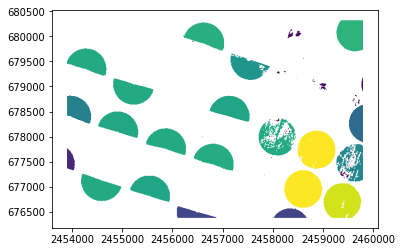

In [12]:
geo_data_frame.plot(column="area")

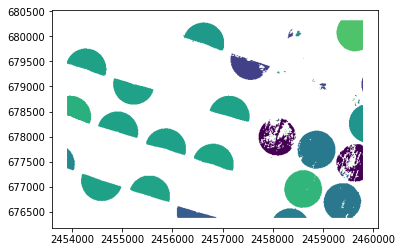

In [11]:
geo_data_frame.plot(column="compactness")